In [134]:
!pip install huggingface_hub tensorflow matplotlib numpy

import os, zipfile, random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download
import pandas as pd
from glob import glob


In [135]:
# Download from the official HuggingFace source
dataset_dir = snapshot_download(
    repo_id="YCAI3/HCI_P2",
    repo_type="dataset",
    local_dir="./HCI_Dataset",
    ignore_patterns=[".gitattributes"]
)

zip_path = os.path.join(dataset_dir, "HCI_Dataset.zip")
extract_dir = os.path.join(dataset_dir, "unzipped")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

base_path = "./HCI_Dataset/unzipped/HCI_Dataset"
print("✅ Dataset extracted to:", base_path)
print("Sample subfolders:", os.listdir(base_path)[:5])


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Dataset extracted to: ./HCI_Dataset/unzipped/HCI_Dataset
Sample subfolders: ['50', '10', '198', '53', '195']


In [136]:
image_paths = glob(os.path.join(base_path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(image_paths))

# Extract label between underscores
def get_label_from_path(path):
    filename = os.path.basename(path)
    parts = filename.split("_")
    if len(parts) >= 3:
        return parts[1]
    return None

data = pd.DataFrame({"path": image_paths, "label": [get_label_from_path(p) for p in image_paths]})
data = data.dropna().reset_index(drop=True)

# 🔹 Small subset for fast training
data = data.sample(15000, random_state=42).reset_index(drop=True)
print("✅ Using subset of", len(data), "samples")
print(data.sample(5))


Total images found: 609656
✅ Using subset of 15000 samples
                                                   path          label
7550  ./HCI_Dataset/unzipped/HCI_Dataset/25/2/301_TU...        TUCUMAN
120   ./HCI_Dataset/unzipped/HCI_Dataset/56/4/310_su...  supernumerary
1833  ./HCI_Dataset/unzipped/HCI_Dataset/92/2/464_LO...          LOOPY
6714  ./HCI_Dataset/unzipped/HCI_Dataset/87/2/493_Ut...        Utterly
3740  ./HCI_Dataset/unzipped/HCI_Dataset/151/2/21_in...      inoculate


In [158]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup
import numpy as np

# 🔹 Build a clean vocabulary with an explicit blank token
all_text = "".join(data["label"].astype(str).tolist())
unique_chars = sorted(list(set(all_text)))
# Add the blank token at the end of the vocabulary for CTC
unique_chars = unique_chars + [""]

print("Vocabulary sample:", unique_chars[:20])
print("Total unique characters (including blank):", len(unique_chars))

# 🔹 Create lookup tables
# Ensure the blank token is at the last index for CTC
char_to_num = StringLookup(vocabulary=unique_chars, oov_token="[UNK]")
# num_to_char needs to be created after char_to_num to get the correct vocabulary order
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

# 🔹 Sanity check
example = "Ernst"
encoded = char_to_num(tf.strings.unicode_split(example, input_encoding="UTF-8"))
decoded = tf.strings.reduce_join(num_to_char(encoded)).numpy().decode('utf-8')

print("Original:", example)
print("Encoded:", encoded.numpy())
print("Decoded:", decoded)
print("char_to_num vocab:", char_to_num.get_vocabulary()[:15])
print("num_to_char vocab:", num_to_char.get_vocabulary()[:15])
print("Blank token index:", char_to_num(""))

Vocabulary sample: ['0', '1', '2', '3', '4', '5', '6', '7', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
Total unique characters (including blank): 62
Original: Ernst
Encoded: [14 53 49 54 55]
Decoded: Ernst
char_to_num vocab: ['[UNK]', np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('9'), np.str_('A'), np.str_('B'), np.str_('C'), np.str_('D'), np.str_('E')]
num_to_char vocab: ['[UNK]', np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('9'), np.str_('A'), np.str_('B'), np.str_('C'), np.str_('D'), np.str_('E')]
Blank token index: tf.Tensor(62, shape=(), dtype=int64)


In [159]:
IMG_HEIGHT, IMG_WIDTH = 32, 128  # smaller = faster

def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH]) / 255.0
    label = char_to_num(tf.strings.unicode_split(label, 'UTF-8'))
    return img, label

dataset = tf.data.Dataset.from_tensor_slices((data["path"].tolist(), data["label"].tolist()))
dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Split into train / val / test
total = len(data)
train_size, val_size = int(0.8*total), int(0.1*total)
train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size).take(val_size)
test_ds  = dataset.skip(train_size+val_size)

BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (train_ds.cache().shuffle(1000)
            .padded_batch(BATCH_SIZE, padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]))
            .prefetch(AUTOTUNE))
val_ds = (val_ds.cache()
          .padded_batch(BATCH_SIZE, padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]))
          .prefetch(AUTOTUNE))
test_ds = (test_ds.cache()
           .padded_batch(BATCH_SIZE, padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]))
           .prefetch(AUTOTUNE))


Encoded: [38 53 50 56 51 44 40 53 54  0  0  0  0]
Decoded: croupiers


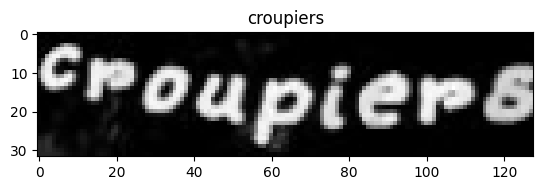

In [160]:
for batch in train_ds.take(1):
  images, labels = batch
  plt.imshow(tf.squeeze(images[0]), cmap='gray')
  decoded = tf.strings.reduce_join(
  num_to_char(tf.gather(labels[0], tf.where(labels[0] != 0)))).numpy().decode("utf-8")
  print("Encoded:", labels[0].numpy())
  print("Decoded:", decoded)
  plt.imshow(tf.squeeze(images[0]), cmap='gray')
  plt.title(decoded)
  plt.show()



In [181]:
def ctc_loss_func(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_len = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_len = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_len = input_len * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_len = label_len * tf.ones(shape=(batch_len, 1), dtype="int64")

    return tf.keras.backend.ctc_batch_cost(
        y_true, y_pred, input_len, label_len
    )

In [182]:
def build_crnn(rnn_type="lstm"):
  input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="image")

  # CNN extractor
  x = layers.Conv2D(32, 3, activation="relu", padding="same")(input_img)
  x = layers.MaxPooling2D(2)(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.MaxPooling2D(2)(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.MaxPooling2D(2)(x)

  new_shape = (IMG_WIDTH // 8, (IMG_HEIGHT // 8) * 128)

  x = layers.Reshape(new_shape)(x)

  # Recurrent part
  if rnn_type == "lstm":
      x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
  else:
      x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)

  output = layers.Dense(len(unique_chars) + 1, activation="softmax")(x)
  return models.Model(inputs=input_img, outputs=output, name=f"crnn_{rnn_type}")


In [183]:
crnn_lstm = build_crnn("lstm")
crnn_gru  = build_crnn("gru")

optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    tf.keras.optimizers.RMSprop(learning_rate=1e-3)
]

for opt in optimizers:
    for model in [crnn_lstm, crnn_gru]:
        model.compile(optimizer=opt, loss=ctc_loss_func)
        history = model.fit(train_ds.take(200),  # small subset for speed
                            validation_data=val_ds.take(50),
                            epochs=3)


Epoch 1/3
 12/188 ━━━━━━━━━━━━━━━━━━━━ 47s 272ms/step - loss: inf

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/ctc_loss_func/CTCLoss defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-3944980111.py", line 12, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 61, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py", line 33, in call

  File "/tmp/ipython-input-1714384672.py", line 9, in ctc_loss_func

  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/backend.py", line 666, in ctc_batch_cost

Not enough time for target transition sequence (required: 17, available: 16)0You can turn this error into a warning by using the flag ignore_longer_outputs_than_inputs
	 [[{{node compile_loss/ctc_loss_func/CTCLoss}}]] [Op:__inference_multi_step_on_iterator_133054]

In [130]:
for model in [crnn_lstm, crnn_gru]:
    loss = model.evaluate(test_ds.take(50))
    print(f"{model.name} Test Loss:", loss)


Image batch shape: (64, 64, 128, 1)


In [131]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("CTC Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Epoch 1/10


  11/7621 ━━━━━━━━━━━━━━━━━━━━ 1:05:51 519ms/step - loss: 53.8378

InvalidArgumentError: Graph execution error:

Detected at node compile_loss/ctc_loss_func/CTCLoss defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-1915820228.py", line 11, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 61, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py", line 33, in call

  File "/tmp/ipython-input-3338693431.py", line 9, in ctc_loss_func

  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/backend.py", line 666, in ctc_batch_cost

Not enough time for target transition sequence (required: 17, available: 16)34You can turn this error into a warning by using the flag ignore_longer_outputs_than_inputs
	 [[{{node compile_loss/ctc_loss_func/CTCLoss}}]] [Op:__inference_multi_step_on_iterator_102916]